In [1]:
import os
import sys
import feather
import joblib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

# project_dir = os.path.dirname(os.path.dirname(os.path.abspath(os.path.curdir)))
project_dir = os.path.dirname(os.path.abspath(os.path.curdir))
new_path = os.path.join(project_dir, 'src')
sys.path.append(new_path)

import util as u
from model import pipeline as p

Load data

In [3]:
df = feather.read_dataframe('../data/processed/test_pred.feather')

In [7]:
df.head()

,url,label,subdomain,domain,suffix,hostname,path,query,subdomain_null_ind,subdomain_www_ind,...,length_path_frac_url_len,length_domain_frac_url_len,url_slash_cnt_frac_url_len,url_digit_cnt_frac_url_len,url_special_char_cnt_frac_url_len,url_reserved_char_cnt_frac_url_len,benign_PREDICT_PROBA,phishing_PREDICT_PROBA,PREDICTION,PRED_CORRECT_IND
0,https://artist.cdjournal.com/d/-/4219040104,benign,artist,cdjournal,com,artist.cdjournal.com,/d/-/4219040104,None,0,0,...,0.348837,0.209302,0.116279,0.232558,0.441860,0.139535,0.998840,0.001160,benign,1
1,https://pittsburgh.cbslocal.com/category/photo...,benign,pittsburgh,cbslocal,com,pittsburgh.cbslocal.com,/category/photo-galleries/page/2/,None,0,0,...,0.515625,0.125000,0.109375,0.015625,0.187500,0.125000,0.998675,0.001325,benign,1
2,https://www.casasdosol.com/imovel/Quintinha-em...,benign,www,casasdosol,com,www.casasdosol.com,/imovel/Quintinha-em-Achete/6205862,None,0,1,...,0.573770,0.163934,0.081967,0.114754,0.311475,0.098361,0.999867,0.000133,benign,1
3,https://www.centroidpm.com/barcelonas-car-free...,benign,www,centroidpm,com,www.centroidpm.com,/barcelonas-car-free-superblocks-could-save-hu...,None,0,1,...,0.761468,0.091743,0.036697,0.000000,0.155963,0.045872,0.999938,0.000062,benign,1
4,http://casinobrend.com/casino-software/thunder...,benign,,casinobrend,com,.casinobrend.com,/casino-software/thunderkick/attachment/thunde...,None,1,0,...,0.721519,0.139241,0.075949,0.000000,0.126582,0.088608,0.999195,0.000805,benign,1


Define y_true & y_pred:

In [102]:
y_true = df['label']
y_pred = df['PREDICTION']

# "Default" model

Analyze "default" model, i.e. with a threshold of 50% (>50% --> Phishing, <50% --> Benign)

Note: the calibration of RandomForest's `predict_proba` is decently calibrated: https://scikit-learn.org/stable/modules/calibration.html

In [103]:
f1 = f1_score(y_true, y_pred, pos_label='phishing')
precision = precision_score(y_true, y_pred, pos_label='phishing')
recall = recall_score(y_true, y_pred, pos_label='phishing')

In [62]:
f1, precision, recall

(0.2015847860538827, 0.99375, 0.11216931216931217)

In [11]:
clf_report = classification_report(y_true, y_pred) #, pos_label='phishing')

In [12]:
print(clf_report)

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00   2480313
    phishing       0.99      0.11      0.20      2835

   micro avg       1.00      1.00      1.00   2483148
   macro avg       1.00      0.56      0.60   2483148
weighted avg       1.00      1.00      1.00   2483148



In [13]:
cm = confusion_matrix(y_true, y_pred)

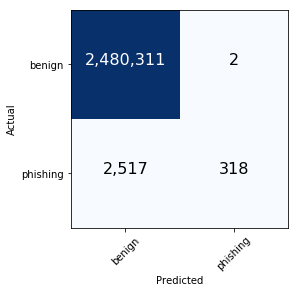

In [36]:
u.plot_conf_matrix(cm, ['benign', 'phishing'])

Define & calculate the False Positive Rate:

In [40]:
def false_pos_rate(tn, fp):
    return 1 - (tn / (tn + fp))

In [41]:
false_pos_rate(cm[0][0], cm[0][1])

8.063498437849148e-07

# Investigate Threshold

For this, we need the probabilities of the positive class (phishing)

In [69]:
y_proba = df['phishing_PREDICT_PROBA']

### Plot the Precision-Recall curve:

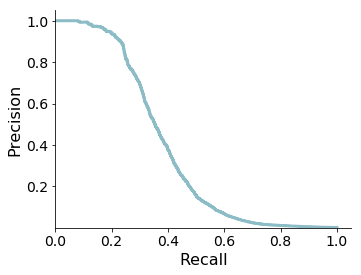

In [118]:
prec, rec = u.plot_prec_recall_curve(y_true, y_proba, pos_label='phishing')

### Plot an example Cost Function

The cost function is generic, and assumes a constant cost per false-negative (fn_cost) and false-positive (fp_cost). The costs are arbitrarily chosen, to demonstrate this approach rather than to be an accurate portrayal of actual cost.

Our labels must be binary:

In [77]:
from sklearn.preprocessing import LabelEncoder

In [84]:
enc = LabelEncoder()
y_true_enc = enc.fit_transform(y_true)

In [86]:
def cost_function(threshold):
    y_pred = np.array(y_proba > threshold)
    
    fpos = y_pred * (1 - y_true_enc) 
    fneg = (1 - y_pred) * y_true_enc
    
    cost_fp = fpos * fp_cost
    cost_fn = fneg * fn_cost
    
    return np.sum(cost_fp + cost_fn)

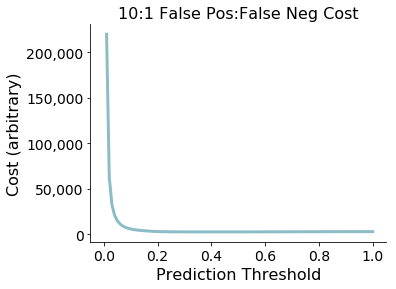

In [109]:
thr_rng = np.linspace(0.01,1,100)
fn_cost = 1
fp_cost = 10

fig = plt.figure(figsize=(5.3,4))
ax = fig.add_subplot(111)

plt.plot(thr_rng, np.vectorize(cost_function)(thr_rng), lw=3, alpha=0.8, color='#70ADBA')

plt.xlim([-0.05, 1.05])
ax.set_ylabel('Cost (arbitrary)', fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ymin, ymax = ax.get_ylim()

plt.xlabel('Prediction Threshold', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('10:1 False Pos:False Neg Cost', fontsize=16);

# plt.legend(loc=(0.80, 0.45), fontsize=16, frameon=False)

We want to minimze our cost, so we would set our threshold around 0.2

In [110]:
thr_opt = 0.2

## Re-calculate model metrics
using this "optimal" threshold

In [111]:
new_y_pred = [1 if x > thr_opt else 0 for x in y_proba]
new_cm = confusion_matrix(y_true_enc, new_y_pred)
new_clf_report = classification_report(y_true_enc, new_y_pred)

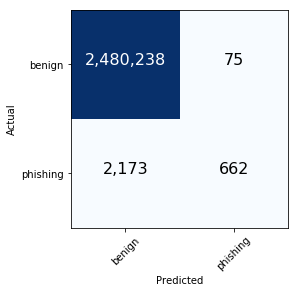

In [114]:
u.plot_conf_matrix(new_cm, labels=['benign', 'phishing'])

In [115]:
print(new_clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2480313
           1       0.90      0.23      0.37      2835

   micro avg       1.00      1.00      1.00   2483148
   macro avg       0.95      0.62      0.69   2483148
weighted avg       1.00      1.00      1.00   2483148



In [116]:
false_pos_rate(new_cm[0][0], new_cm[0][1])

3.0238119140602038e-05

In [117]:
f1 = f1_score(y_true_enc, new_y_pred)
precision = precision_score(y_true_enc, new_y_pred)
recall = recall_score(y_true_enc, new_y_pred)
f1, precision, recall

(0.37066069428891374, 0.898236092265943, 0.23350970017636685)